In [1]:
%reset
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import fooof
from fooof import FOOOF

import numpy as np
import pandas as pd
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

import os
import warnings
warnings.filterwarnings('ignore')

import mne
from mne import io

def data_eeg(chandat, srate):
    # make the PSD
    window_size = int(srate*10)
    overlap = int(window_size * 0.5)

    xf, _, psd_array = signal.spectrogram(chandat, fs=srate, window=('hanning'), nperseg=window_size, noverlap=overlap)
    psd_array = psd_array.astype('float64')
    psd_array = np.nanmean(psd_array,1)
    psd_array = np.log10(psd_array)

    return psd_array, xf


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
10/2409 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading eegwm/11-JS.fdt
CPU times: user 48.8 ms, sys: 79 µs, total: 48.8 ms
Wall time: 25 ms

                                          FOOOF - PSD MODEL                                          

                     The input PSD was modelled in the frequency range 1-40 Hz                      
                                 Frequency Resolution is 0.10 Hz 
                                  
                                      Background Parameters:                                        
                                     -9.5892, -2.7215, 3.84e-22                                     

                                      3 oscillations were found:                 

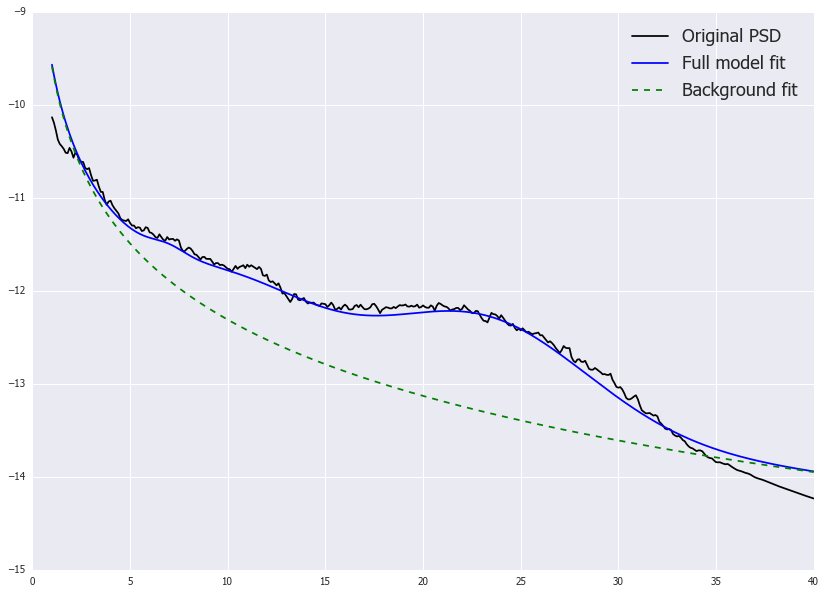

In [3]:
fname = 'eegwm/11-JS.set'

raw = io.read_raw_eeglab(fname)

data, times = raw[0:64, :]
srate = raw.info['sfreq']

chan_i = 38
psd_array, freqs = data_eeg(data[chan_i,:], srate)
ff = FOOOF()
f_range = [1, 40]
%time ff.fit(freqs, psd_array, f_range)
ff.model(freqs, psd_array, f_range)

In [3]:
col_file = []
col_chan = []
col_cf = []
col_amp = []
col_bw = []
col_offset = []
col_slope = []
col_curve = []

eeg_chans = range(0,64)
f_range = [1, 40]

my_dir = '/Users/Voytek/fooof/eegwm'
for file in os.listdir(my_dir):
    if file.endswith('.set'):
        filename = os.path.join(my_dir, file)
        
        raw = io.read_raw_eeglab(filename)

        data, times = raw[eeg_chans, :]
        srate = raw.info['sfreq']

        for chan_i in range(np.shape(data)[0]):
            psd_array, freqs = data_eeg(data[chan_i,:], srate)

            ff = FOOOF()
            ff.fit(freqs, psd_array, f_range)
            oscillation_params = ff.oscillation_params
            background_params = ff.background_params

            if np.any(oscillation_params):
                for i in range(np.shape(oscillation_params)[0]):
                    col_cf.append(oscillation_params[i][0])
                    col_amp.append(oscillation_params[i][1])
                    col_bw.append(oscillation_params[i][2])
                    col_offset.append(background_params[0])
                    col_slope.append(background_params[1])
                    col_curve.append(background_params[2])
                    col_file.append(file)
                    col_chan.append((chan_i + 1))
            else:
                col_cf.append(0)
                col_amp.append(0)
                col_bw.append(0)
                col_offset.append(background_params[0])
                col_slope.append(background_params[1])
                col_curve.append(background_params[2])
                col_file.append(file)
                col_chan.append((chan_i + 1))


The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
10/2409 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading /Users/Voytek/fooof/eegwm/11-JS.fdt
The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
10/2409 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading /Users/Voytek/fooof/eegwm/12-DF.fdt
The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
8/1927 event codes could not be mapped to integers. Use the 'event_id' p

In [4]:
d = {'file': col_file, 'chan': col_chan, 'cf': col_cf, 'amp': col_amp, 'bw': col_bw, 'offset': col_offset, 'slope': col_slope, 'curve': col_curve}
df = pd.DataFrame(data=d)
df = df[['file', 'chan', 'cf', 'amp', 'bw', 'offset', 'slope', 'curve']]
df.to_csv('wm_eeg.csv', sep=',', index = False)

In [5]:
df = pd.read_csv('wm_eeg.csv')
df = df[df['bw'] > 1.0001]

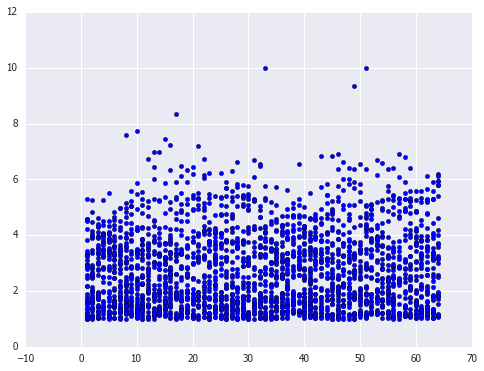

In [12]:
plt.scatter(df['chan'], df['bw'])
plt.show()

In [104]:
import mne
from mne.datasets import sample
from mne.preprocessing import create_ecg_epochs, create_eog_epochs

fname = 'eegwm/15-LH.set'

raw = io.read_raw_eeglab(fname, preload=True)

data, times = raw[0:67, :]
srate = raw.info['sfreq']

raw, _ = mne.set_eeg_reference(raw, ['A1', 'A2'])

raw.set_channel_types(mapping={'LO1': 'eog'})
raw.set_channel_types(mapping={'LO2': 'eog'})
raw.set_channel_types(mapping={'IO1': 'eog'})
raw.set_channel_types(mapping={'A1': 'misc'})
raw.set_channel_types(mapping={'A2': 'misc'})

events = mne.find_events(raw, stim_channel='STI 014')


The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
8/1927 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading eegwm/15-LH.fdt
Reading 0 ... 568061  =      0.000 ...  2218.988 secs...
Applying a custom EEG reference.


In [105]:
print(raw.info)
print(raw.ch_names)

<Info | 16 non-empty fields
    bads : 'list | 0 items
    buffer_size_sec : 'float | 1.0
    ch_names : 'list | Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, ...
    chs : 'list | 70 items (EEG: 64, STIM: 1, EOG: 3, MISC: 2)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | True
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : 'list | 0 items
    highpass : 'float | 0.0 Hz
    hpi_meas : 'list | 0 items
    hpi_results : 'list | 0 items
    lowpass : 'float | 128.0 Hz
    meas_date : 'numpy.ndarray | 1969-12-31 16:00:00
    nchan : 'int | 70
    projs : 'list | 0 items
    sfreq : 'float | 256.0 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    description : 'NoneType
    dev_ctf_t : 'NoneType
    dig : 'NoneType
    experimenter : 'NoneType
    file_id : 'NoneType
    hpi_subsystem : 'NoneType
    kit_system_id : 'NoneType
    line_freq : 'NoneType
    meas_id : 'NoneType
    proj_id : 'NoneType
    proj_name : 'NoneType
    su

In [109]:
tmin, tmax = -0.1, 1.6
reject = dict(eeg=180e-6, eog=100e-6)
event_id = {'L1-1': 201, 'L2-1': 205, 'L3-1': 209,
            'L1-2': 202, 'L2-2': 206, 'L3-2': 210}
epochs_params = dict(events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=(-0.1,0), reject=reject)
epochs = mne.Epochs(raw, **epochs_params)
print(epochs)

all_evokeds = [epochs[cond].average() for cond in sorted(event_id.keys())]
print(all_evokeds)

foo = mne.combine_evoked(all_evokeds, weights=(0.25, 0.25, 0.25, 0.25, 0.25, 0.25))

320 matching events found
0 projection items activated
<Epochs  |  n_events : 320 (good & bad), tmin : -0.1015625 (s), tmax : 1.6015625 (s), baseline : (-0.1, 0), ~120 kB, data not loaded,
 'L1-1': 48, 'L1-2': 56, 'L2-1': 56, 'L2-2': 56, 'L3-1': 56, 'L3-2': 48>
    Rejecting  epoch based on EOG : ['IO1']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P5', 'P7', 'PO3', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP2', 'P2', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', '

319 matching events found
0 projection items activated
<Epochs  |  n_events : 319 (good & bad), tmin : -0.1015625 (s), tmax : 1.6015625 (s), baseline : (-0.1, 0), ~120 kB, data not loaded,
 'R1-1': 56, 'R1-2': 56, 'R2-1': 56, 'R2-2': 56, 'R3-1': 48, 'R3-2': 47>
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EOG : ['IO1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P7', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'C4', 'C6', 'T8', 'CP6', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'P4', 'P6', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1

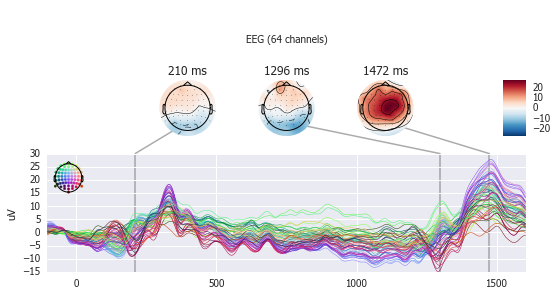

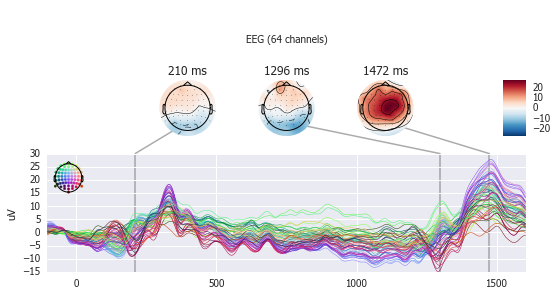

In [110]:
tmin, tmax = -0.1, 1.6
reject = dict(eeg=180e-6, eog=100e-6)
event_id = {'R1-1': 203, 'R2-1': 207, 'R3-1': 211,
            'R1-2': 204, 'R2-2': 208, 'R3-2': 212}
epochs_params = dict(events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=(-0.1,0), reject=reject)
epochs = mne.Epochs(raw, **epochs_params)
print(epochs)

all_evokeds = [epochs[cond].average() for cond in sorted(event_id.keys())]
print(all_evokeds)

mne.combine_evoked(all_evokeds, weights=(0.25, 0.25, 0.25, 0.25, 0.25, 0.25)).plot_joint()

    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EOG : ['IO1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P7', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'C4', 'C6', 'T8', 'CP6', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'TP7', 'CP5', 'P5', 'P7', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'CPz', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'P4', 'P6', 'P10', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EOG : ['IO1']
    Rejecting  epoch based on EOG : ['LO1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EOG : ['IO1']
    Rejecting  epoch based 

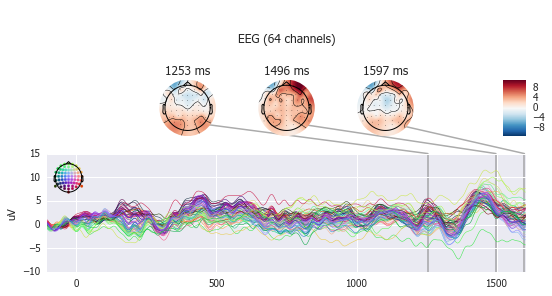

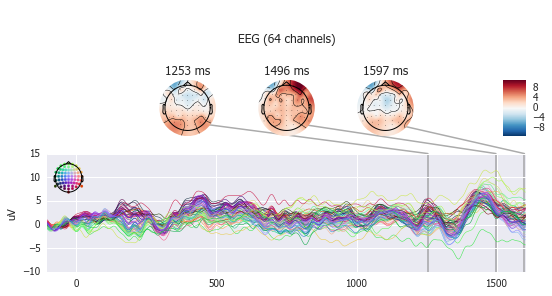

In [81]:
l1, l3 = epochs["R1-1"].average(), epochs["R3-1"].average()
# create and plot difference ERP
mne.combine_evoked([l1, -l3], weights='equal').plot_joint()


In [91]:
dir(foo)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__neg__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_aspect_kind',
 '_data',
 '_get_channel_positions',
 '_get_check_picks',
 '_pick_drop_channels',
 '_projector',
 '_set_channel_positions',
 '_size',
 'add_channels',
 'add_proj',
 'animate_topomap',
 'anonymize',
 'apply_baseline',
 'apply_proj',
 'as_type',
 'ch_names',
 'comment',
 'compensation_grade',
 'copy',
 'crop',
 'data',
 'decimate',
 'del_proj',
 'detrend',
 'drop_channels',
 'first',
 'get_peak',
 'info',
 'interpolate_bads',
 'kind',
 'last',
 'nave',
 'pick_channels',
 'pick_types',
 'picks',
 'plot',
 'plot_field',
 'plot_image',
 'plot_joint',
 'plot_projs_topomap',
 'plot_sensor

In [93]:
np.shape(foo.data)

(64, 437)

In [95]:
dir(epochs)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bad_dropped',
 '_channel_type_idx',
 '_compute_mean_or_stderr',
 '_data',
 '_decim',
 '_decim_slice',
 '_detrend_offset_decim',
 '_do_delayed_proj',
 '_evoked_from_epoch_data',
 '_filename',
 '_get_channel_positions',
 '_get_check_picks',
 '_get_data',
 '_get_epoch_from_raw',
 '_is_good_epoch',
 '_keys_to_idx',
 '_name',
 '_offset',
 '_pick_drop_channels',
 '_project_epoch',
 '_projector',
 '_raw',
 '_raw_times',
 '_reject_setup',
 '_reject_time',
 '_set_channel_positions',
 '_size',
 'add_channels',
 'add_proj',
 'anonymize',
 'apply_baseline',
 'apply_

In [114]:
trial_data = epochs._get_data()

Loading data for 269 events and 437 original time points ...


In [117]:
np.shape(trial_data)

(269, 70, 437)